In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
from operator import attrgetter
from ordered_set import OrderedSet
# if you use conda run this in your terminal: conda install -c conda-forge ordered-set
import gurobipy as gb

In [2]:
# local files
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import *
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = False
C = 15
L = 2

map_size = 100
ratio_locker_customers = 0.3

In [4]:
def get_nearest_store(stores, location):
    min_distance = float("inf")
    nearest_store = stores[0]
    for store in stores:
        distance = location.euclidean_distance(store.location)
        if distance < min_distance:
            min_distance = distance
            nearest_store = store
    return nearest_store

In [5]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(0, Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(1, Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(2, Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(0, 0, Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(1, 0, Location(20, 40)))
    customers.append(DoorToDoorCustomer(2, 1, Location(15, 70)))
    customers.append(DoorToDoorCustomer(3, 2, Location(30, 70)))
    customers.append(DoorToDoorCustomer(4, 3, Location(80, 60)))
    customers.append(LockerCustomer(5, 1, Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(6, 4, Location(90, 50)))
    customers.append(LockerCustomer(7, 2, Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(0, Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf"),
                        is_warehouse=True))
    for l in range(L):
        stores.append(Store(l + 1, Location(random.randint(0, map_size), random.randint(0, map_size)),
                            capacity=math.ceil(0.8 * C / L)))

    customers = []
    counter_locker_customer = 0
    counter_door_to_door_customer = 0
    for c in range(C):
        location = Location(random.randint(0, map_size), random.randint(0, map_size))
        if random.random() < ratio_locker_customers:
            # customer locker
            customers.append(LockerCustomer(c, counter_locker_customer, location, get_nearest_store(stores, location)))
            counter_locker_customer += 1
        else:
            # door to door customer
            customers.append(DoorToDoorCustomer(c, counter_door_to_door_customer, location))
            counter_door_to_door_customer += 1

In [6]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(1, VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(2, VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(3, VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(0, VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(1, VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(store.index + 1, VehicleType.LF, store, math.ceil(0.6 * store.capacity)))

In [7]:
# define some np.array to plot the map
CD_location = np.array([[0, 0]])
CL_location = np.array([[0, 0]])
L_location = np.array([[0, 0]])
W_location = np.array([[0, 0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

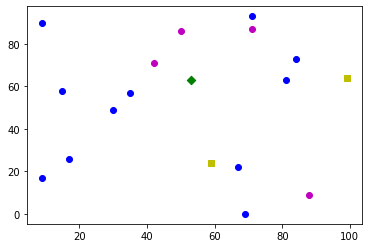

In [8]:
# plot the map
plt.scatter(CD_location[:, 0], CD_location[:, 1], color='b')
plt.scatter(CL_location[:, 0], CL_location[:, 1], color='m')
plt.scatter(W_location[:, 0], W_location[:, 1], color='g', marker='D')
plt.scatter(L_location[:, 0], L_location[:, 1], color='y', marker='s')

In [9]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations, W_location)
all_locations = np.vstack([all_locations, L_location])
all_locations = np.vstack([all_locations, CD_location])
all_locations = np.vstack([all_locations, CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy = dist_matrix.to_numpy()
print(dist_matrix)


              W          L1         L2        CD0        CD1        CD2  \
W      0.000000   46.010868  39.458839  38.327536  18.973666  28.000000   
L1    46.010868    0.000000  56.568542  84.214013  64.381674  18.027756   
L2    39.458839   56.568542   0.000000  55.605755  40.804412  44.777226   
CD0   38.327536   84.214013  55.605755   0.000000  20.024984  66.189123   
CD1   18.973666   64.381674  40.804412  20.024984   0.000000  46.389654   
CD2   28.000000   18.027756  44.777226  66.189123  46.389654   0.000000   
CD3   32.572995   17.492856  55.009090  70.611614  51.546096  10.440307   
CD4   51.623638   93.680307  82.800966  32.557641  42.011903  76.896034   
CD5   63.655322  101.533246  50.487622  41.436699  47.707442  85.440037   
CD6   26.925824   70.611614  38.288379  17.492856   9.433981  52.886671   
CD7   65.000000   70.682388  26.000000  79.246451  66.370174  64.132675   
CD8   34.985711   40.311289  70.035705  66.037868  50.911688  31.622777   
CD9   51.623638   90.3769

In [10]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers + C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)

            W         L1         L2
W    0.000000  46.010868  39.458839
L1  46.010868   0.000000  56.568542
L2  39.458839  56.568542   0.000000
              W        CD0        CD1        CD2        CD3         CD4  \
W      0.000000  38.327536  18.973666  28.000000  32.572995   51.623638   
CD0   38.327536   0.000000  20.024984  66.189123  70.611614   32.557641   
CD1   18.973666  20.024984   0.000000  46.389654  51.546096   42.011903   
CD2   28.000000  66.189123  46.389654   0.000000  10.440307   76.896034   
CD3   32.572995  70.611614  51.546096  10.440307   0.000000   76.902536   
CD4   51.623638  32.557641  42.011903  76.896034  76.902536    0.000000   
CD5   63.655322  41.436699  47.707442  85.440037  93.600214   73.000000   
CD6   26.925824  17.492856   9.433981  52.886671  59.093147   46.065171   
CD7   65.000000  79.246451  66.370174  64.132675  74.525164  108.166538   
CD8   34.985711  66.037868  50.911688  31.622777  23.853721   62.072538   
CD9   51.623638  32.062439  35.

In [11]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi * PF_distances_matrix
LF_delivery_cost = pi_l * LF_distances_matrix
supply_cost = pi_L * supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2
W    0.000000  34.508151  29.594129
L1  34.508151   0.000000  42.426407
L2  29.594129  42.426407   0.000000
              W        CD0        CD1        CD2        CD3         CD4  \
W      0.000000  38.327536  18.973666  28.000000  32.572995   51.623638   
CD0   38.327536   0.000000  20.024984  66.189123  70.611614   32.557641   
CD1   18.973666  20.024984   0.000000  46.389654  51.546096   42.011903   
CD2   28.000000  66.189123  46.389654   0.000000  10.440307   76.896034   
CD3   32.572995  70.611614  51.546096  10.440307   0.000000   76.902536   
CD4   51.623638  32.557641  42.011903  76.896034  76.902536    0.000000   
CD5   63.655322  41.436699  47.707442  85.440037  93.600214   73.000000   
CD6   26.925824  17.492856   9.433981  52.886671  59.093147   46.065171   
CD7   65.000000  79.246451  66.370174  64.132675  74.525164  108.166538   
CD8   34.985711  66.037868  50.911688  31.622777  23.853721   62.072538   
CD9   51.623638  32.062439  35.

In [12]:

LF_delivery_cost_multidim = np.zeros((L, len(C_D) + 1, len(C_D) + 1))

for i in range(L):
    l = [0]
    l[0] = lockers[i]
    ls = LF_delivery_cost.filter(items=l + C_D, axis=1)
    ls = ls.filter(items=l + C_D, axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1 + len(C_D)):
        for k in range(1 + len(C_D)):
            LF_delivery_cost_multidim[i][j][k] = lt[j][k]


             L1        CD0        CD1        CD2        CD3        CD4  \
L1     0.000000  71.581911  54.724423  15.323593  14.868927  79.628261   
CD0   71.581911   0.000000  17.021237  56.260755  60.019872  27.673995   
CD1   54.724423  17.021237   0.000000  39.431206  43.814181  35.710118   
CD2   15.323593  56.260755  39.431206   0.000000   8.874261  65.361629   
CD3   14.868927  60.019872  43.814181   8.874261   0.000000  65.367155   
CD4   79.628261  27.673995  35.710118  65.361629  65.367155   0.000000   
CD5   86.303259  35.221194  40.551326  72.624032  79.560182  62.050000   
CD6   60.019872  14.868927   8.018884  44.953671  50.229175  39.155396   
CD7   60.080030  67.359483  56.414648  54.512774  63.346389  91.941558   
CD8   34.264595  56.132188  43.274935  26.879360  20.275663  52.761657   
CD9   76.820440  27.253073  30.469862  62.836793  69.565113  54.823353   
CD10  44.881288  53.758720  40.310079  36.825704  45.694912  75.969270   

            CD5        CD6        CD7

In [13]:

col_ind = []
d_ak_k = []
index_close_locker = []
min_value = []
Sk_def = []
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes = []
#compensation

compensation_matrix = dist_matrix.filter(items=stores + C_D, axis=1)
compensation_matrix = compensation_matrix.filter(items=stores + C_D, axis=0)

distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L, axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores, axis=0)

closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
min_value_col = distance_matrix_customer_locker_store.min()

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(str(closest_store_to_CL[i]))
    min_value.append(min_value_col[i])

for i in range(len(C_L)):
    col_ind.append("D_" + str(index_close_locker[i]) + "_" + str(C_L[i].index))

d_ak_k = pd.DataFrame(min_value, index=col_ind)

pre_d_c_k = dist_matrix.filter(items=C_D, axis=0)
pre_d_c_k = pre_d_c_k.filter(items=C_L, axis=1)

d_ak_c = pd.DataFrame()

# insert d_c_k
for cl in C_L:
    # Using DataFrame.insert() to add a column
    store = cl.store
    array = []
    for cd in C_D:
        distance = store.location.euclidean_distance(cd.location)
        array.append(distance)
    d_ak_c.insert(len(d_ak_c.columns), store, array, True)

d_c_k = dist_matrix.filter(items=C_D, axis=0)
d_c_k = d_c_k.filter(items=C_L, axis=1)

sum_dck_dakc = d_ak_c.to_numpy() + d_c_k.to_numpy()


def find_Sk(cd, cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd] <= 1.5 * d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd' + str(cd))
    return S_K_i


for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl] <= 1.5 * d_ak_k.to_numpy()[cl]:
            OC.append('Cl' + str(cl))
            Sk_def.append('CD' + str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))


def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list


OC_unique = unique(OC)

Sk = unique(Sk_def)
Sk = sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))

S_k = []

for cd in C_D:
    for s in range(len(Sk)):
        if str(cd) == Sk[s]:
            S_k.append(cd)

index_of_cl_associated_to_closest_locker = []
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i] + '->' + locker_where_oc_goes[OC.index(OC_unique[i])])

big_matrix = np.zeros((len(C_D), len(C_L)))
big_matrix = pd.DataFrame(big_matrix, index=C_D, columns=C_L)

for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]] = d_ak_c.values[position_sk[i]][position_cl[i]]

OC = []
for i in C_L:
    is_all_null = True
    for j in range(len(C_D)):
        if big_matrix.values[j][i.locker_customer_index] != 0:
            is_all_null = False
            OC.append(i)
OC = list(OrderedSet(OC))

filter_cd_sk = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            filter_cd_sk.append(cd)

d_cd_oc = big_matrix.filter(items=OC, axis=1)
d_ak_c = d_cd_oc.filter(items=S_k, axis=0)
d_ak_c.columns = index_of_cl_associated_to_closest_locker
print(d_ak_c)
d_ak_c = d_ak_c.to_numpy()

pck = 0.5 * d_ak_c
for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k] == 0:
            pck[c][k] = 100000

print(pck)

lockers_wrt_their_oc_matrix = dist_matrix.filter(items=OC, axis=1)
lockers_wrt_their_oc_matrix = lockers_wrt_their_oc_matrix.filter(items=stores, axis=0)

lockers_wrt_their_oc = lockers_wrt_their_oc_matrix.idxmin()

lockers_wrt_their_oc_array = []
for i in range(len(OC_unique)):
    lockers_wrt_their_oc_array.append(lockers_wrt_their_oc[i])




         Cl0->W    Cl1->L2
CD7    0.000000  26.000000
CD8   34.985711   0.000000
CD10   0.000000   8.246211
[[1.00000000e+05 1.30000000e+01]
 [1.74928557e+01 1.00000000e+05]
 [1.00000000e+05 4.12310563e+00]]


In [14]:
env = gb.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

single_period_problem = gb.Model()
single_period_problem.modelSense = gb.GRB.MINIMIZE  #declare minimization


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-11


In [15]:
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)

I_L = 1 + L
J_L = 1 + L

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)

# add var to the problem
x_i_j = single_period_problem.addVars([(i, j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.BINARY)
x_i_j_L = single_period_problem.addVars([(i, j) for i in range(I_L) for j in range(J_L)], vtype=gb.GRB.BINARY)
x_l_i_j = single_period_problem.addVars([(l, i, j) for i in range(I_LF) for j in range(J_PF) for l in range(L)],
                                        vtype=gb.GRB.BINARY)

y_i_j = single_period_problem.addVars([(i, j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.INTEGER)
y_i_j_L = single_period_problem.addVars([(i, j) for i in range(I_L) for j in range(J_L)], vtype=gb.GRB.INTEGER)
y_l_i_j = single_period_problem.addVars([(l, i, j,) for i in range(I_LF) for j in range(J_PF) for l in range(L)],
                                        vtype=gb.GRB.INTEGER)

z_c = single_period_problem.addVars([c for c in range(len(C_D))], vtype=gb.GRB.BINARY)
z_c_l = single_period_problem.addVars([(l, c) for c in range(len(C_D)) for l in range(L)], vtype=gb.GRB.BINARY)
z_l_L = single_period_problem.addVars([l for l in range(L)], vtype=gb.GRB.BINARY)

w_c_k = single_period_problem.addVars([(c, k) for k in range(len(OC_unique)) for c in range(len(Sk))],
                                      vtype=gb.GRB.BINARY, name="w_c_k")

In [16]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr(
        z_c[c] + gb.quicksum(w_c_k[s, k] for s in range(len(Sk)) for k in range(len(OC_unique))
                             if C_D[c] == filter_cd_sk[s]) + gb.quicksum(z_c_l[l, c] for l in range(L)) == 1)
# constraint eq. 3
for k in range(len(OC_unique)):
    single_period_problem.addConstr(gb.quicksum(w_c_k[s_k, k] for s_k in range(len(Sk))) <= 1)

# constraint eq. 4
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand * w_c_k[sk, k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index - 1] == lockers_wrt_their_oc_array[k]) +
        gb.quicksum(C_D[cd].package_demand * z_c_l[l.index - 1, cd] for cd in range(len(C_D)))
        <= l.capacity * z_l_L[l.index - 1]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum(x_i_j[i + 1, j] for j in range(len(C_D) + 1))
        == z_c[i]
    )

# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum(x_i_j[j, i + 1] for j in range(len(C_D) + 1))
        == z_c[i]
    )

# constraint eq. 6
single_period_problem.addConstr(
    gb.quicksum(x_i_j[0, j + 1] for j in range(len(C_D)))
    - gb.quicksum(x_i_j[j + 1, 0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum(y_i_j[j, i + 1] for j in range(1 + len(C_D)))
        - gb.quicksum(y_i_j[i + 1, j] for j in range(1 + len(C_D)))
        == C_D[i].package_demand * z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstr(
    gb.quicksum(y_i_j[j + 1, 0] for j in range(len(C_D)))
    - gb.quicksum(y_i_j[0, j + 1] for j in range(len(C_D)))
    == - gb.quicksum(C_D[i].package_demand * z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstr(
            y_i_j[i, j]
            <= vehicles[1].capacity * x_i_j[i, j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstr(
        y_i_j[i + 1, 0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum(x_i_j_L[i + 1, j] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum(x_i_j_L[j, i + 1] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 12
single_period_problem.addConstr(
    gb.quicksum(x_i_j_L[0, j + 1] for j in range(L))
    - gb.quicksum(x_i_j_L[j + 1, 0] for j in range(L))
    == 0
)

# constraint eq. 13
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum(y_i_j_L[j, l.index] for j in range(1 + L))
        - gb.quicksum(y_i_j_L[l.index, j] for j in range(1 + L))
        ==
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand * w_c_k[sk, k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index - 1] == lockers_wrt_their_oc_array[k])
        + gb.quicksum(C_D[c].package_demand * z_c_l[l.index - 1, c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstr(
    gb.quicksum(y_i_j_L[j + 1, 0] for j in range(L))
    - gb.quicksum(y_i_j_L[0, j + 1] for j in range(L))
    == - gb.quicksum(
        gb.quicksum(cl.package_demand for cl in l.find_associated_CL(customers, stores))
        +
        gb.quicksum(S_k[sk].package_demand * w_c_k[sk, k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                    if lockers[l.index - 1] == lockers_wrt_their_oc_array[k])
        + gb.quicksum(C_D[c].package_demand * z_c_l[l.index - 1, c] for c in range(len(C_D)))
        for l in lockers
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstr(
            y_i_j_L[i, j]
            <= vehicles[0].capacity * x_i_j_L[i, j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstr(
        y_i_j_L[i + 1, 0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum(x_l_i_j[l, i + 1, j] for j in range(len(C_D) + 1))
            == z_c_l[l, i]
        )

    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum(x_l_i_j[l, j, i + 1] for j in range(len(C_D) + 1))
            == z_c_l[l, i]
        )

    # constraint eq. 18
    single_period_problem.addConstr(
        gb.quicksum(x_l_i_j[l, 0, j + 1] for j in range(len(C_D)))
        - gb.quicksum(x_l_i_j[l, j + 1, 0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum(y_l_i_j[l, j, i + 1] for j in range(1 + len(C_D)))
            - gb.quicksum(y_l_i_j[l, i + 1, j] for j in range(1 + len(C_D)))
            == C_D[i].package_demand * z_c_l[l, i]
        )

    # constraint eq. 20
    single_period_problem.addConstr(
        gb.quicksum(y_l_i_j[l, j + 1, 0] for j in range(len(C_D)))
        - gb.quicksum(y_l_i_j[l, 0, j + 1] for j in range(len(C_D)))
        == - gb.quicksum(C_D[i].package_demand * z_c_l[l, i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstr(
                y_l_i_j[l, i, j]
                <= vehicles[l + 2].capacity * x_l_i_j[l, i, j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            y_l_i_j[l, i + 1, 0]
            == 0
        )



In [17]:
single_period_problem.setObjective(
    gb.quicksum(gb.quicksum(supply_cost.values[i][j] * x_i_j_L[i, j] for j in range(1 + L)) for i in range(1 + L)) +
    gb.quicksum(gb.quicksum(pck[c][k] * w_c_k[c, k] for c in range(len(Sk))) for k in range(len(OC_unique))) +
    gb.quicksum(gb.quicksum(PF_delivery_cost.values[i][j] * x_i_j[i, j] for j in range(1 + len(C_D))) for i in
                range(1 + len(C_D))) +
    gb.quicksum(gb.quicksum(gb.quicksum(LF_delivery_cost_multidim[l][i][j] * x_l_i_j[l, i, j]
                                        for j in range(1 + len(C_D))) for i in range(1 + len(C_D))) for l in range(L))
)

single_period_problem.optimize()  #equivalent to solve() for xpress

print("---------single_period_problem.status--------")
print(single_period_problem.status)
# https://www.gurobi.com/documentation/9.5/refman/optimization_status_codes.html

print("-----------single_period_problem.Runtime-----------------")
print(single_period_problem.Runtime)
# https://www.gurobi.com/documentation/9.5/refman/runtime.html

print("-------single_period_problem.ObjVal----------")
print(single_period_problem.ObjVal)
#https://www.gurobi.com/documentation/9.5/refman/objval.html#attr:ObjVal


print("\n", type(x_i_j), x_i_j, "\n")
print("\nSolution")
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        if x_i_j[i, j].x == 1:  #to access the variable value
            print("from ", i, " to ", j)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 604 rows, 923 columns and 2853 nonzeros
Model fingerprint: 0xf0ee2f60
Variable types: 0 continuous, 923 integer (482 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 114 rows and 117 columns
Presolve time: 0.04s
Presolved: 490 rows, 806 columns, 2518 nonzeros
Variable types: 0 continuous, 806 integer (439 binary)
Found heuristic solution: objective 100783.14879
Found heuristic solution: objective 849.0289805

Root relaxation: objective 2.611055e+02, 493 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  261.10549    0   15  849.02898  261.10549 

xpress with custom_setup = True:
Final MIP objective                   : 1.978326002278371e+02

gurobi with custom_setup = True
Best objective 1.978326002278e+02

In [18]:
print(single_period_problem.getJSONSolution())

{ "SolutionInfo": { "Status": 2, "Runtime": 3.0902695655822754e-01, "Work": 1.3144143817353041e-01, "ObjVal": 3.6719987793895353e+02, "ObjBound": 3.6719987793895353e+02, "ObjBoundC": 3.6719987837395604e+02, "MIPGap": 0, "IntVio": 1.2185008957388277e-06, "BoundVio": 3.8939951929606309e-07, "ConstrVio": 9.8560040972697136e-07, "IterCount": 2058, "BarIterCount": 0, "NodeCount": 1, "SolCount": 8, "PoolObjBound": 3.6719987837395604e+02, "PoolObjVal": [ 3.6719987793895353e+02, 375.973466057749, 4.0234467665665488e+02, 4.0863804479455587e+02, 4.2774547833851972e+02, 5.3645863988136159e+02, 8.4902898045180177e+02, 1.0078314879330015e+05]}, "Vars": [ { "VarName": "C0", "X": 1}, { "VarName": "C2", "X": -5.0908369347100437e-09}, { "VarName": "C3", "X": 9.9999967265697109e-01}, { "VarName": "C4", "X": 7.0631989504342243e-08}, { "VarName": "C5", "X": 9.9999995058530033e-01}, { "VarName": "C17", "X": 5.8244353523286491e-08}, { "VarName": "C18", "X": 9.9999969749143458e-01}, { "VarName": "C19", "X": 

In [20]:
CL_dictionary = {}

j = 0
for oc in OC:
    i = 0
    for sk in S_k:
        string = "w_c_k[" + str(i) + "," + str(j) + "]"
        if single_period_problem.getVarByName(string).x == 1:
            CL_dictionary[oc] = sk
        i += 1
    j += 1
print(CL_dictionary)

{}
